本教程是使用决策树和tf.estimatorAPI 训练Gradient Boosting模型的端到端演练。Boosted Trees模型是用于回归和分类的最流行和最有效的机器学习方法之一。这是一种综合技术，将几种（例如10s，100s甚至1000s）树模型的预测结合在一起。

Boosted Trees模型在许多机器学习从业者中很受欢迎，因为它们可以通过最少的超参数调整来获得令人印象深刻的性能。

加载泰坦尼克号数据集

您将使用泰坦尼克号数据集，其中（而不是病态）目标是根据给定的特征（例如性别，年龄，阶级等）来预测乘客的生存。

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
from IPython.display import clear_output
from matplotlib import pyplot as plt

# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

数据集由训练集和评估集组成：

* dftrain并且y_train是在训练设定的模型使用学习-The数据。
* 该模型对测试EVAL集，dfeval和y_eval。

为了进行培训，您将使用以下功能：

|Feature Name|	Description|
|-|-|
|sex|	Gender of passenger|
|age|	Age of passenger|
|n_siblings_spouses|	# siblings and partners aboard|
|parch|	# of parents and children aboard|
|fare|	Fare passenger paid.|
|class|	Passenger's class on ship|
|deck|	Which deck passenger was on|
|embark_town|	Which town passenger embarked from|
|alone|	If passenger was alone|

|功能名称|	描述|
|-|-|
|sex|	旅客性别|
|age|	乘客年龄|
|n_siblings_spouses|	＃兄弟姐妹和伙伴|
|parch|	父母和子女人数|
|fare|	票价乘客已付。|
|class|	船上乘客舱|
|deck|	哪位甲板乘客在|
|embark_town|	哪个镇上的乘客出发|
|alone|	如果乘客一个人|

探索数据

首先，让我们预览一些数据并在训练集中创建摘要统计信息。

In [2]:
import tensorflow as tf
tf.random.set_seed(123)

In [3]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [4]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


训练和评估集中分别有627个和264个示例。

In [5]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

大部分乘客都在20多岁和30多岁之间。

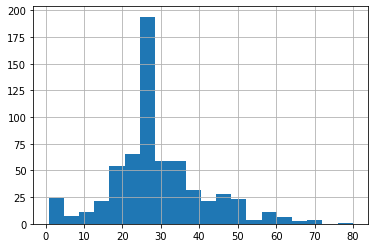

In [6]:
dftrain.age.hist(bins=20)
plt.show()

男性乘客大约是女性乘客的两倍。

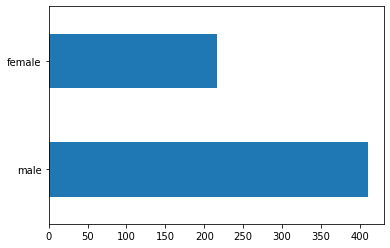

In [7]:
dftrain.sex.value_counts().plot(kind='barh')
plt.show()

大多数乘客属于“三等”舱。

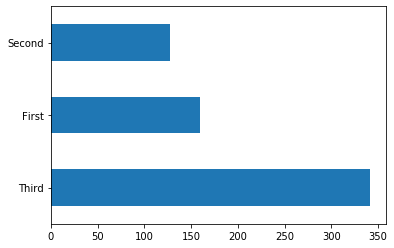

In [8]:
dftrain['class'].value_counts().plot(kind='barh')
plt.show()

大多数乘客从南安普敦出发。

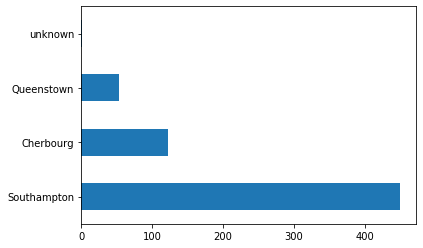

In [9]:
dftrain['embark_town'].value_counts().plot(kind='barh')
plt.show()

与男性相比，女性生存的机会要高得多。显然，这将是模型的预测功能。

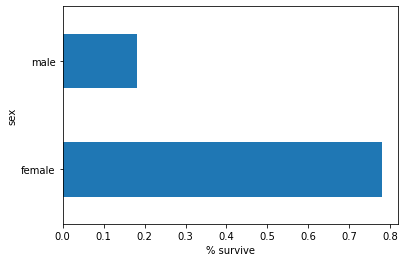

In [10]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')
plt.show()

创建要素列和输入函数

梯度提升估计器可以利用数字和分类特征。特征列可与所有TensorFlow估计器一起使用，其目的是定义用于建模的特征。此外，它们还提供了一些功能工程功能，例如单热编码，规范化和存储桶化。在本教程中，其中的字段CATEGORICAL_COLUMNS从分类列转换为一键编码的列（指示符列）：

In [11]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
    return tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    # Need to one-hot encode categorical features.
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                           dtype=tf.float32))

您可以查看要素列产生的转换。例如，这是在indicator_column单个示例上使用时的输出：

In [12]:
example = dict(dftrain.head(1))
class_fc = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('class', ('First', 'Second', 'Third')))
print('Feature value: "{}"'.format(example['class'].iloc[0]))
print('One-hot encoded: ', tf.keras.layers.DenseFeatures([class_fc])(example).numpy())

Feature value: "Third"
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
One-hot encoded:  [[0. 0. 1.]]


此外，您可以一起查看所有功能列转换：

In [13]:
tf.keras.layers.DenseFeatures(feature_columns)(example).numpy()

array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)

接下来，您需要创建输入函数。这些将指定如何将数据读入我们的模型进行训练和推理。您将使用API中的from_tensor_slices方法tf.data直接从Pandas中读取数据。这适用于较小的内存数据集。对于较大的数据集，tf.data API支持多种文件格式（包括csv），因此您可以处理内存中不适合的数据集。

In [14]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        # For training, cycle thru dataset as many times as need (n_epochs=None).
        dataset = dataset.repeat(n_epochs)
        # In memory training doesn't use batching.
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

训练和评估模型
在下面，您将执行以下步骤：

1. 初始化模型，指定特征和超参数。
1. 使用将训练数据输入模型，train_input_fn并使用train函数训练模型。
1. 您将使用评估集（在本示例中为dfevalDataFrame）评估模型性能。您将验证预测是否与y_eval数组中的标签匹配。

在训练Boosted Trees模型之前，让我们首先训练线性分类器（逻辑回归模型）。最佳做法是从更简单的模型开始建立基准。

In [15]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

# Train model.
linear_est.train(train_input_fn, max_steps=100)

# Evaluation.
result = linear_est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.765152
accuracy_baseline         0.625000
auc                       0.832844
auc_precision_recall      0.789631
average_loss              0.478908
label/mean                0.375000
loss                      0.478908
precision                 0.703297
prediction/mean           0.350790
recall                    0.646465
global_step             100.000000
dtype: float64


接下来，让我们训练Boosted Trees模型。对于增强树，支持回归（BoostedTreesRegressor）和分类（BoostedTreesClassifier）。由于目标是预测类别生存-还是不生存，因此您将使用BoostedTreesClassifier。

In [16]:
# Since data fits into memory, use entire dataset per layer. It will be faster.
# Above one batch is defined as the entire dataset.
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

# The model will stop training once the specified number of trees is built, not
# based on the number of steps.
est.train(train_input_fn, max_steps=100)

# Eval.
result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.829545
accuracy_baseline         0.625000
auc                       0.872788
auc_precision_recall      0.857807
average_loss              0.411839
label/mean                0.375000
loss                      0.411839
precision                 0.793478
prediction/mean           0.381942
recall                    0.737374
global_step             100.000000
dtype: float64


现在，您可以使用火车模型从评估集中对乘客进行预测。优化TensorFlow模型以一次对一批或一组示例进行预测。之前，eval_input_fn使用整个评估集来定义。

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\30660\AppData\Local\Temp\tmp4v0sm86z\model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


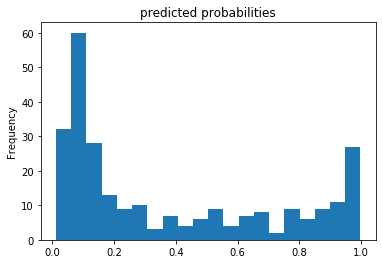

In [17]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()

最后，您还可以查看结果的接收器工作特性（ROC），这将使我们更好地了解真阳性率和假阳性率之间的折衷。

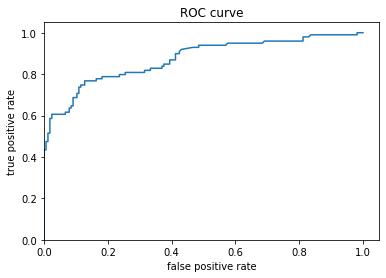

In [18]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()